<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/02_GNN_message_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Graph Neural Network

After completing this chapter, you should be able to

  * Discuss and categorize common graph neural network architectures
  * Build a GNN and choose a read-out function for the type of labels

A graph neural network (GNN) is a neural network with two defining attributes:

1. Its input is a graph
2. Its output is permutation equivariant

We can understand clearly the first point. Here, a graph permutation means re-ordering our nodes. In our methanol example above, we could have easily made the carbon be atom 1 instead of atom 4. Our new adjacency matrix would then be:

|    | 1  | 2  | 3  | 4  | 5  | 6  |
|:---|----|----|----|----|----|---:|
| 1  | 0  | 1  | 1  | 1  | 1  |  0 |
| 2  | 1  | 0  | 0  | 0  | 0  |  0 |
| 3  | 1  | 0  | 0  | 0  | 0  |  0 |
| 4  | 1  | 0  | 0  | 0  | 1  |  0 |
| 5  | 1  | 0  | 0  | 0  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


A GNN is permutation equivariant if the output change the same way as these exchanges. If you are trying to model a per-atom quantity like partial charge or chemical shift, this is obviously essential. If you change the order of atoms input, you would expect the order of their partial charges to similarly change.

Often we want to model a whole-molecule property, like solubility or energy. This should be **invariant** to changing the order of the atoms. To make an equivariant model invariant, we use read-outs (defined below).

### A simple GNN

We will often mention a GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. Let's see an example of a simple layer for a GNN:

\begin{equation}
f_k = \sigma\left( \sum_i \sum_j v_{ij}w_{jk}  \right)
\end{equation}

This equation shows that we first multiply every node ($v_{ij}$) feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. Is this equation permutation invariant? Yes, because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

Let's see an example that is similar, but not permutation invariant:

\begin{equation}
f_k = \sigma\left( \sum_i v_{ij}w_{ik}  \right)
\end{equation}

This is a small change. We have one weight vector per node now. This makes the trainable weights depend on the ordering of the nodes. Then if we swap the node ordering, our weights will no longer align. So if we were to input two methanol molecules, which should have the same output, but we switched two atom numbers, we would get different answers. These simple examples differ from real GNNs in two important ways: (i) they give a single feature vector output, which throws away per-node information, and (ii) they do not use the adjacency matrix. Let's see a real GNN that has these properties while maintaining permutation invariance --- or equivariance (swapping inputs swaps outputs the same way).

## Kipf & Welling GCN

One of the first popular GNNs was the Kipf & Welling graph convolutional network (GCN) {cite}`kipf2016semi`. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically the Kipf & Welling GCN.
Thomas Kipf has written an [excellent article introducing the GCN](https://tkipf.github.io/graph-convolutional-networks/).

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V}'$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neighbors, as determined by $\mathbf{E}$. The choice of averaging over neighbors is what makes a GCN layer permutation equivariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

$$
v_{il} = \sigma\left(\frac{1}{d_i}e_{ij}v_{jk}w_{kl}\right)
$$

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the output node feature, $d_i$ is the degree of node i (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have $1$s on the diagonal instead of $0$ by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs. You can view the GCN layer as a way to "communicate" between a node and its neighbors. The output for node $i$ will depend only on its immediate neighbors. For chemistry, this is not satisfactory. You can stack multiple layers though. If you have two layers, the output for node $i$ will include information about node $i$'s neighbors' neighbors. Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals: (i) it gives permutation equivariance by removing the effect of neighbor order and (ii) it prevents a change in magnitude in node features. A sum would accomplish (i) but would cause the magnitude of the node features to grow after each layer. Of course, you could ad-hoc put a batch normalization layer after each GCN layer to keep output magnitudes stable but averaging is easy.

In [14]:
!pip install rdkit myst_nb moviepy

In [15]:
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl # plotting
import numpy as np # array manipulation
import tensorflow as tf
import pandas as pd # dataframe manipulation
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw # chemical processing
import networkx as nx # visualization
from myst_nb import glue
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [16]:
def smiles2graph(sml):
    """Argument for the smiles2graph function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [17]:
my_elements = { 6: "C",  8: "O", 1: "H"}
nodes, adj = smiles2graph("CO")

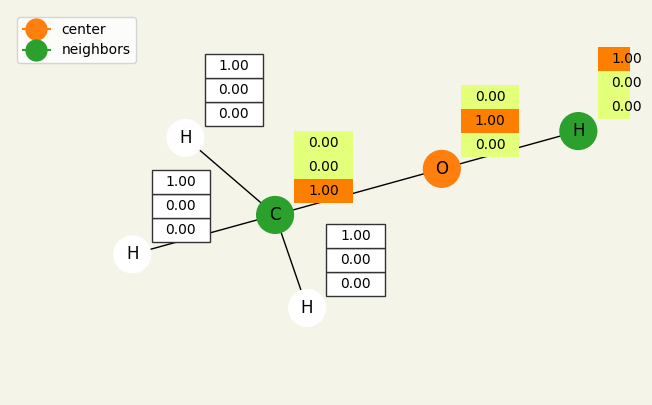

In [24]:
def draw_vector(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        if cmap is not None:
            ax.add_patch(
                mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(vi), **kwargs)
            )
        else:
            ax.add_patch(
                mpl.patches.Rectangle(
                    (x, y), s * 1.5, s, facecolor="#FFF", edgecolor="#333", **kwargs
                )
            )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            "{:.2f}".format(vi),
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s


def draw_key(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        ax.add_patch(
            mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(1.0), **kwargs)
        )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            vi,
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s
    ax.text(
        x, y + s / 2, "Key:", verticalalignment="center", horizontalalignment="left"
    )


def draw(
    nodes, adj, ax, highlight=None, key=False, labels=None, mask=None, draw_nodes=None
):
    G = nx.Graph()
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if np.any(adj[i, j]):
                G.add_edge(i, j)
    if mask is None:
        mask = [True] * len(G)
    if draw_nodes is None:
        draw_nodes = nodes
    # go from atomic number to element
    elements = np.argmax(draw_nodes, axis=-1)
    el_labels = {i: list(my_elements.values())[e] for i, e in enumerate(elements)}
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")
    except ImportError:
        pos = nx.spring_layout(G, iterations=100, seed=4, k=1)
    pos = nx.rescale_layout_dict(pos)
    c = ["white"] * len(G)
    all_h = []
    if highlight is not None:
        for i, h in enumerate(highlight):
            for hj in h:
                c[hj] = "C{}".format(i + 1)
                all_h.append(hj)
    nx.draw(G, ax=ax, pos=pos, labels=el_labels, node_size=700, node_color=c)
    cmap = plt.get_cmap("Wistia")
    for i in range(len(G)):
        if not mask[i]:
            continue
        if i in all_h:
            draw_vector(*pos[i], 0.15, nodes[i], ax, cmap)
        else:
            draw_vector(*pos[i], 0.15, nodes[i], ax, None)
    if key:
        draw_key(-1, -1, 0.15, my_elements.values(), ax, cmap)
    if labels is not None:
        legend_elements = []
        for i, l in enumerate(labels):
            p = mpl.lines.Line2D(
                [0], [0], marker="o", color="C{}".format(i + 1), label=l, markersize=15
            )
            legend_elements.append(p)
        ax.legend(handles=legend_elements)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_facecolor("#f5f4e9")


fig = plt.figure(figsize=(8, 5))
draw(nodes, adj, plt.gca(), highlight=[[1], [5, 0]], labels=["center", "neighbors"])
fig.set_facecolor("#f5f4e9")
glue("dframe", plt.gcf(), display=False)

[0] 0 5 0
[False, False, False, False, False, True] 5


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

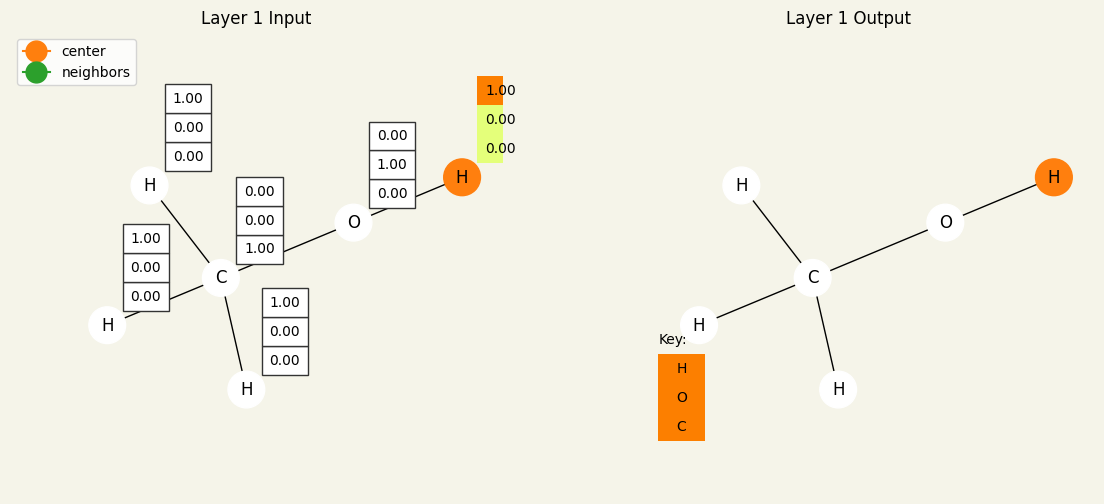

In [25]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
fig, axs = plt.subplots(1, 2, squeeze=True, figsize=(14, 6), dpi=100)
order = [5, 1, 0, 2, 3, 4]
time_per_node = 2
last_layer = [0]
layers = 2
input_nodes = np.copy(nodes)
fig.set_facecolor("#f5f4e9")


def make_frame(t):
    axs[0].clear()
    axs[1].clear()

    layer_i = int(t / (time_per_node * len(order)))
    axs[0].set_title(f"Layer {layer_i + 1} Input")
    axs[1].set_title(f"Layer {layer_i + 1} Output")

    flat_adj = np.sum(adj, axis=-1)
    out_nodes = np.einsum(
        "i,ij,jk->ik",
        1 / (np.sum(flat_adj, axis=1) + 1),
        flat_adj + np.eye(*flat_adj.shape),
        nodes,
    )

    if last_layer[0] != layer_i:
        print("recomputing")
        nodes[:] = out_nodes
        last_layer[0] = layer_i

    t -= layer_i * time_per_node * len(order)
    i = order[int(t / time_per_node)]
    print(last_layer, layer_i, i, t)
    mask = [False] * nodes.shape[0]
    for j in order[: int(t / time_per_node) + 1]:
        mask[j] = True
    print(mask, i)
    neighs = list(np.where(adj[i])[0])
    if (t - int(t / time_per_node) * time_per_node) >= time_per_node / 4:
        draw(
            nodes,
            adj,
            axs[0],
            highlight=[[i], neighs],
            labels=["center", "neighbors"],
            draw_nodes=input_nodes,
        )
    else:
        draw(
            nodes,
            adj,
            axs[0],
            highlight=[[i]],
            labels=["center", "neighbors"],
            draw_nodes=input_nodes,
        )
    if (t - int(t / time_per_node) * time_per_node) < time_per_node / 2:
        mask[j] = False
    draw(
        out_nodes,
        adj,
        axs[1],
        highlight=[[i]],
        key=True,
        mask=mask,
        draw_nodes=input_nodes,
    )
    fig.set_facecolor("#f5f4e9")
    return mplfig_to_npimage(fig)


animation = VideoClip(make_frame, duration=time_per_node * nodes.shape[0] * layers)

animation.write_gif("../content/gcn.gif", fps=2)

### Exercise

Let's repeat the same process for Ethanol `(CCO)`.

1. Convert the smiles into the graph.
2. How many nodes the graph contain? What is the number of rows and columns for the graph?
3. Show the adjancy matrix for the Ethanol
4. show the adjacancy list for ethanol
5. Perform one-step of message passing for each atom in this molecules. Consider the identity matrix for weights.